In [55]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

In [34]:
def f_linear(m,b,x):
    """ Linear Function """
    return m*x+b
def f_parabola(a,b,c,x):
    """ parabola function """
    return  a*x**2.0 + b*x + c

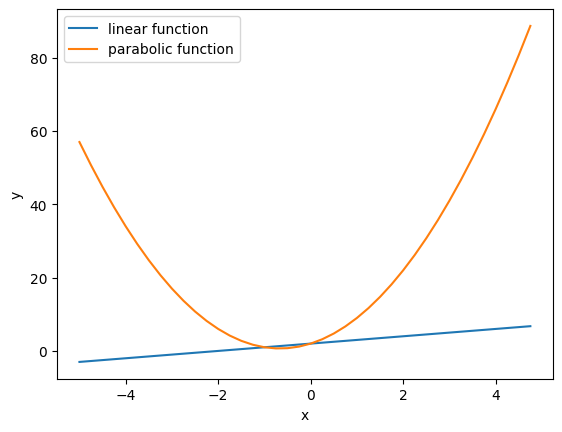

In [12]:
x = np.arange(-5,5,0.25)
yl = f_linear(1,2,x)
yp = f_parabola(3,4,2,x)
plt.plot(x,yl,label="linear function")
plt.plot(x,yp,label="parabolic function")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [43]:
h = 0.001
x = 3.0
f_parabola(3.0,4.0,2.0,x)

41.0

In [45]:
(f_parabola(3,4,2,x+h) -  f_parabola(3,4,2,x))/h

22.002999999997996

In [50]:
## more example
a = 2.0
b = -3.0
c = 10.0
h = 0.0001
d = a*b + c
da = (a+h)*b + c
db = a*(b+h) + c
dc = a*b + (c+h)

print("d : ",d)
print("da : ",da)
print("db : ",db)
print("dc : ",dc)

# slope
print("slope when a changes: ", (da - d)/h )
print("slope when b changes: ", (db - d)/h )
print("slope when c changes: ", (dc - d)/h )



d :  4.0
da :  3.999699999999999
db :  4.0002
dc :  4.0001
slope when a changes:  -3.000000000010772
slope when b changes:  2.0000000000042206
slope when c changes:  0.9999999999976694


# create core Value object

In [67]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data,(self, other),"+")
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data,(self, other), "*")
        return out
    

a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a*c; e.label = 'e'
d = e + c; d.label = 'd'
d, d._prev

(Value(data=30.0), (Value(data=20.0), Value(data=10.0)))

In [ ]:
at 54:00 neuron